In [113]:
#Imports

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np
%matplotlib inline

In [114]:
#Load in our data

In [34]:
data = pd.read_csv(   'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']

### Data exploration

In [118]:
data_visual

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.10,0.00,0.00,9779.80
2018-01-14,0.00,5349.65,2218.93,13245.19
2018-01-21,0.00,4235.86,2046.96,12022.66
2018-01-28,0.00,3562.21,0.00,8846.95
2018-02-04,0.00,0.00,2187.29,9797.07
...,...,...,...,...
2021-10-03,0.00,0.00,1691.68,9030.17
2021-10-10,11543.58,4615.35,2518.88,15904.11
2021-10-17,0.00,4556.16,1919.19,12839.29


In [123]:
data_visual = data.copy()
data_visual.rename(columns={"TV":"TV Spend","Radio":"Radio Spend","Banners":"Online Banners Spend","Sales":"Product Sales"},inplace=True)
data_visual

,TV Spend,Radio Spend,Online Banners Spend,Product Sales
Date,,,,
2018-01-07,13528.10,0.00,0.00,9779.80
2018-01-14,0.00,5349.65,2218.93,13245.19
2018-01-21,0.00,4235.86,2046.96,12022.66
2018-01-28,0.00,3562.21,0.00,8846.95
2018-02-04,0.00,0.00,2187.29,9797.07
...,...,...,...,...
2021-10-03,0.00,0.00,1691.68,9030.17
2021-10-10,11543.58,4615.35,2518.88,15904.11
2021-10-17,0.00,4556.16,1919.19,12839.29


## Attempt w/ Linear Regression

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import pandas as pd
data = pd.read_csv(
    'https://raw.githubusercontent.com/Garve/datasets/4576d323bf2b66c906d5130d686245ad205505cf/mmm.csv',
    parse_dates=['Date'],
    index_col='Date'
)
X = data.drop(columns=['Sales'])
y = data['Sales']
lr = LinearRegression()
print(f'cross val scores {cross_val_score(lr, X, y, cv=TimeSeriesSplit())}')
print(f'mean cross val score {np.mean(cross_val_score(lr, X, y, cv=TimeSeriesSplit()))}')

cross val scores [0.69594303 0.69302285 0.66850729 0.78807363 0.73512387]
mean cross val score 0.716134134746767


In [37]:
lr.fit(X,y)

LinearRegression()

In [164]:
lr.coef_

array([0.34864303, 0.45999642, 1.20617133])

In [163]:
#Return coeficients for each type of marketing spend
lr_coef_table = pd.DataFrame(lr.coef_.flatten())
lr_coef_table.index = list(X.columns)
lr_coef_table = lr_coef_table.rename(columns={0:"Coef"})
lr_coef_table

,Coef
TV,0.348643
Radio,0.459996
Banners,1.206171


In [42]:
#Return the y intercept, which is the baseline in our marketing mix model
baseline = lr.intercept_
baseline

6678.396933606161

In [166]:
#Test our lr on a single week of spend data
test_week_spend = data.loc["2021-10-10"][0:3].values

#Use sample week spend data to predict sales
spend_test_prediction = lr.predict(([test_week_spend]))[0]

#Now use our lr to attempt a prediction using this selected week's spend figure and our lr's coeficients
print(f'lr sales prediction {spend_test_prediction}')
print(f'Actual sales {data.loc["2021-10-10"][3]}')
print(f'Delta {spend_test_prediction-data.loc["2021-10-10"][3]}')

lr sales prediction 15992.602810755861
Actual sales 15904.11
Delta 88.49281075586077


In [89]:
#Next find a correlation factor using truth and predictions
correl_factor = data.loc["2021-10-10"][3]/spend_test_prediction
correl_factor

0.9944666411213349

In [90]:
sample_week = pd.DataFrame(data.loc["2021-10-10"])
sample_week["Actual Spend/Sales"] = sample_week["2021-10-10"]
sample_week.drop(sample_week.columns[0], axis=1,inplace=True)
sample_week["Coef"] = 0
sample_week["Coef"] = lr_coef_table
sample_week

,Actual Spend/Sales,Coef
TV,11543.58,0.359684
Radio,4615.35,0.488332
Banners,2518.88,1.215919
Sales,15904.11,NaN


In [91]:
#Create a baseline row that equal to y intercept with 1 for coeficient
sample_week.loc[len(sample_week.index)] = [(baseline),1]
sample_week = sample_week.rename(index={4:"Baseline"})
sample_week = sample_week.reindex(["TV","Radio","Banners","Baseline","Sales"])
sample_week

,Actual Spend/Sales,Coef
TV,11543.580000,0.359684
Radio,4615.350000,0.488332
Banners,2518.880000,1.215919
Baseline,6678.396934,1.000000
Sales,15904.110000,NaN


In [92]:
#Make predictions based on our acutal spend numbers, coeficients and correlation factor
sample_week["Predicted Sales"]= sample_week["Actual Spend/Sales"]*correl_factor*sample_week["Coef"]
sample_week["Predicted Sales"][4] = sum(sample_week["Predicted Sales"][0:4])
sample_week

,Actual Spend/Sales,Coef,Predicted Sales
TV,11543.580000,0.359684,4129.064241
Radio,4615.350000,0.488332,2241.354012
Banners,2518.880000,1.215919,3045.807488
Baseline,6678.396934,1.000000,6641.442967
Sales,15904.110000,NaN,16057.668708


In [93]:
#Great, our predictions were accurate!

In [94]:
weights = pd.Series(lr.coef_,index=X.columns)
#unadjusted_sales_predictions = weights

In [95]:
weights

TV         0.348643
Radio      0.459996
Banners    1.206171
dtype: float64

In [96]:
#Create a Dataframe that contains the product of weights and spend numbers, this will need to be adjusted by the correl factor
unadj_contributions = X.copy()
unadj_contributions["TV"] = unadj_contributions["TV"]*weights.TV
unadj_contributions["Radio"] = unadj_contributions["Radio"]*weights.Radio
unadj_contributions["Banners"] = unadj_contributions["Banners"]*weights.Banners
unadj_contributions["Base"] = baseline
unadj_contributions

,TV,Radio,Banners,Base
Date,,,,
2018-01-07,4716.477776,0.000000,0.000000,6678.396934
2018-01-14,0.000000,2460.819869,2676.409744,6678.396934
2018-01-21,0.000000,1948.480452,2468.984461,6678.396934
2018-01-28,0.000000,1638.603861,0.000000,6678.396934
2018-02-04,0.000000,0.000000,2638.246484,6678.396934
...,...,...,...,...
2021-10-03,0.000000,0.000000,2040.455912,6678.396934
2021-10-10,4024.588710,2123.044495,3038.200834,6678.396934
2021-10-17,0.000000,2095.817307,2314.871951,6678.396934


In [101]:
adjusted_contributions = (unadj_contributions.div(unadj_contributions.sum(axis=1), axis=0).mul(y, axis=0))
adjusted_contributions["Total Predicted Spend"] =  adjusted_contributions.sum(axis=1)
adjusted_contributions

,TV,Radio,Banners,Base,Total Predicted Spend
Date,,,,,
2018-01-07,4047.978633,0.000000,0.000000,5731.821367,9779.80
2018-01-14,0.000000,2758.552549,3000.226475,7486.410977,13245.19
2018-01-21,0.000000,2111.230143,2675.210014,7236.219843,12022.66
2018-01-28,0.000000,1743.013712,0.000000,7103.936288,8846.95
2018-02-04,0.000000,0.000000,2774.291590,7022.778410,9797.07
...,...,...,...,...,...
2021-10-03,0.000000,0.000000,2113.312851,6916.857149,9030.17
2021-10-10,4034.705600,2128.381341,3045.838172,6695.184887,15904.11
2021-10-17,0.000000,2426.602673,2680.230974,7732.456353,12839.29


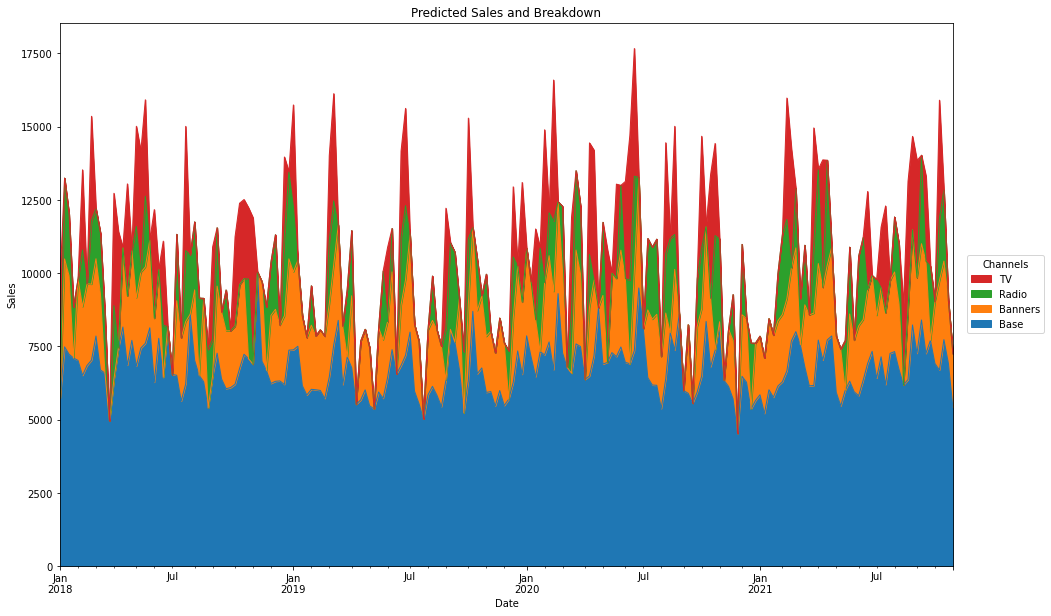

In [102]:
ax = (adjusted_contributions[['Base', 'Banners', 'Radio', 'TV']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
);

In [103]:
roi = {'TV':[],'Radio':[],'Banners':[]}
for channel in roi:
    roi[channel] = adjusted_contributions[channel].sum()/data[channel].sum()
roi

{'TV': 0.3543542091142607,
 'Radio': 0.46846052075285427,
 'Banners': 1.2158330929777321}

In [104]:
r2_score(y_true=y,y_pred=adjusted_contributions["Total Predicted Spend"])

1.0

In [ ]:
# We had a perfect r2 number but that's not exactly fair because we saw all the data and learned it's pattern.
#Let's see how the model does on unseen data.

### Attempt on unseen data

In [105]:
#Split our data into 2/3 for training and 1/3 for eval

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)
#lr.score(X_test, y_test)

LinearRegression()

In [106]:
test_week_spend = data.loc["2021-10-10"][0:3].values

In [107]:
#Use sample week spend data to predict sales
spend_test_prediction = lr.predict(([test_week_spend]))[0]

In [108]:
#Now use our lr to attempt a prediction using this selected week's spend figure and our lr's coeficients
print(f'lr sales prediction {spend_test_prediction}')
print(f'Actual sales {data.loc["2021-10-10"][3]}')
print(f'Delta {spend_test_prediction-data.loc["2021-10-10"][3]}')

lr sales prediction 15992.602810755861
Actual sales 15904.11
Delta 88.49281075586077


In [81]:
#Next find a correlation factor using truth and predictions
correl_factor = data.loc["2021-10-10"][3]/spend_test_prediction
correl_factor

0.9944666411213349

In [83]:
weights = pd.Series(lr.coef_,index=X_train.columns)
#unadjusted_sales_predictions = weights
weights

TV         0.348643
Radio      0.459996
Banners    1.206171
dtype: float64

In [109]:
#Now on the x_test
#Create a Dataframe that contains the product of weights and spend numbers, this will need to be adjusted by the correl factor
unadj_contributions = X_test.copy()
unadj_contributions["TV"] = unadj_contributions["TV"]*weights.TV
unadj_contributions["Radio"] = unadj_contributions["Radio"]*weights.Radio
unadj_contributions["Banners"] = unadj_contributions["Banners"]*weights.Banners
unadj_contributions["Base"] = baseline
unadj_contributions

,TV,Radio,Banners,Base
Date,,,,
2019-11-03,0.000000,2389.354825,2152.509228,6678.396934
2018-04-22,3719.097228,0.000000,2300.325524,6678.396934
2018-08-05,0.000000,2204.808860,2289.916266,6678.396934
2021-01-17,0.000000,0.000000,2690.775245,6678.396934
2020-06-21,3955.212233,2906.781802,2490.707607,6678.396934
...,...,...,...,...
2019-11-17,0.000000,0.000000,2212.130277,6678.396934
2018-08-12,0.000000,2704.861772,0.000000,6678.396934
2018-04-01,4017.092885,2621.271222,0.000000,6678.396934


In [110]:
#Now we adjust the contributions based on our naive correl factor from training
adjusted_contributions = unadj_contributions.mul(correl_factor,axis=0)
adjusted_contributions["Total Predicted Spend"] =  adjusted_contributions.sum(axis=1)
adjusted_contributions

,TV,Radio,Banners,Base,Total Predicted Spend
Date,,,,,
2019-11-03,0.000000,2376.133667,2140.598622,6641.442967,11158.175256
2018-04-22,3698.518128,0.000000,2287.596998,6641.442967,12627.558092
2018-08-05,0.000000,2192.608861,2277.245337,6641.442967,11111.297165
2021-01-17,0.000000,0.000000,2675.886220,6641.442967,9317.329186
2020-06-21,3933.326625,2890.697536,2476.925628,6641.442967,15942.392754
...,...,...,...,...,...
2019-11-17,0.000000,0.000000,2199.889766,6641.442967,8841.332733
2018-08-12,0.000000,2689.894801,0.000000,6641.442967,9331.337768
2018-04-01,3994.864868,2606.766788,0.000000,6641.442967,13243.074622


In [111]:
r2_score(y_true=y_test,y_pred=adjusted_contributions["Total Predicted Spend"])

0.8232431652722243

In [112]:
#Our r2 is understandably lower but still pretty strong at 0.8!

### Simple linear regression on unseen data

In [124]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test, y_test)

0.8261056233741675

In [137]:
total_spend = X.copy()
total_spend["Spend Total"] = total_spend["TV"] + total_spend["Radio"] +total_spend["Banners"]
total_spend = total_spend[["Spend Total"]]

''

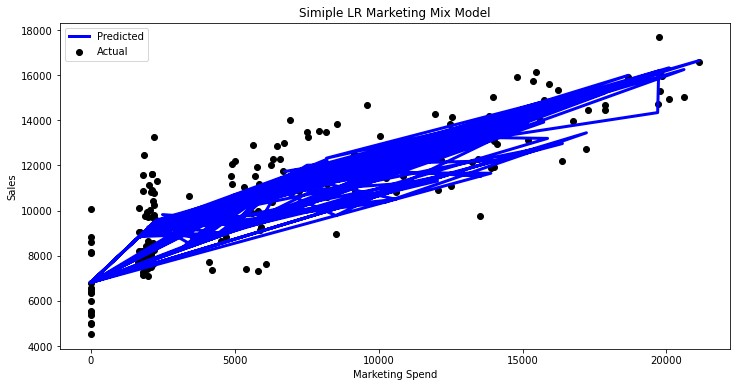

In [165]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(total_spend, y,color="black")
ax.plot(total_spend, lr.predict(X), color="blue", linewidth=3)
ax.set_xlabel("Marketing Spend")
ax.set_ylabel("Sales")
ax.legend(["Predicted","Actual"])
ax.set_title("Simiple LR Marketing Mix Model")
plt.savefig('Images/Simiple_LR_MMM.png')
;